# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [331]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


#### **1.2** Import necessary libraries

In [332]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')
#!pip install numpy spacy 

In [333]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [334]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [335]:
# define a function to load json file to a dataframe
def load_ingredient_data(json_path):
    """
    Reads the ingredient_and_quantity.json file and converts it into a pandas DataFrame.

    Parameters:
        json_path (str): Path to the JSON file.

    Returns:
        pd.DataFrame: DataFrame with two columns - 'input' and 'pos'
    """
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    df = pd.DataFrame(data)
    return df
#df = load_ingredient_data("ingredient_and_quantity.json")
#print(df.head())

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [336]:
# read the json file by giving the file path and create a dataframe
df = load_ingredient_data("ingredient_and_quantity.json")
#print(df.head())

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [337]:
# display first five rows of the dataframe - df
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                  1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                           1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                                 qua

In [338]:
# print the dimensions of dataframe - df
df.shape

(285, 2)

In [339]:
# print the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [340]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
df['input_tokens'] = df['input'].apply(lambda x: x.split())
# Tokenize POS
df['pos_tokens'] = df['pos'].apply(lambda x: x.split())

In [341]:
# display first five rows of the dataframe - df
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]                               

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [342]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

In [343]:
# check for the equality of input_length and pos_length in the dataframe
df['length_match'] = df['input_length'] == df['pos_length']
# Show rows where lengths do NOT match
mismatch_df = df[~df['length_match']]
print(mismatch_df[['input_tokens', 'pos_tokens', 'input_length', 'pos_length']])

                                                                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_length  pos_length
17    

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [344]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df):
    """
    Finds and prints all unique POS labels from the 'pos_tokens' column.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'pos_tokens' as lists
    """
    # Flatten all pos_tokens lists and get unique values
    unique = set(label for sublist in df['pos_tokens'] for label in sublist)
    
    print("Unique POS labels found:")
    for label in sorted(unique):
        print(f"- {label}")
#unique_labels(df)

##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>


In [345]:
invalid_indexes = df[~df['length_match']].index.tolist()
print(f"Total rows needing cleaning: {len(invalid_indexes)}")
print("Indexes:", invalid_indexes)

Total rows needing cleaning: 5
Indexes: [17, 27, 79, 164, 207]


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [346]:
# drop the irrelevant recipe data
cleaned_df = df[df['length_match']].reset_index(drop=True)
print(f"Dropped {len(df) - len(cleaned_df)} invalid rows.")
cleaned_df.head()

Dropped 5 invalid rows.


input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_length  pos_length  length_match
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31          True
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew,

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [347]:
# update the input and pos length in input_length and pos_length
cleaned_df['input_length'] = cleaned_df['input_tokens'].apply(len)
cleaned_df['pos_length'] = cleaned_df['pos_tokens'].apply(len)
print(cleaned_df[['input_length', 'pos_length']].head())

   input_length  pos_length
0            31          31
1            34          34
2            37          37
3            46          46
4            21          21


##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [348]:
# validate the input length and pos length as input_length and pos_length
df = cleaned_df
invalid_rows = df[df['input_length'] != df['pos_length']]


if not invalid_rows.empty:
    print("Mismatch found in the following rows:")
    display(invalid_rows[['input', 'pos', 'input_length', 'pos_length']])
    print(False)
else:
    print("All rows are valid (input_length == pos_length).")
    print(True)

All rows are valid (input_length == pos_length).
True


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [349]:
# split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)
print(f"Split complete: {len(train_df)} training rows, {len(val_df)} validation rows.")
train_df.reset_index(drop=True)
val_df.reset_index(drop=True)

Split complete: 196 training rows, 84 validation rows.


input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                                                                                                        input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        pos_tokens  input_length  pos_length  length_match
0                                                                                                                                                                                                                                                                                       1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi                                                                                                                                                                                                                                                                                                                                                                                                                                                     quantity unit ingredient quantity unit ingredient quantity ingredient unit ingredient quantity unit ingredient ingredient ingredient                                                                                                                                                                                                                                                                                                                               [1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]            15          15          True
1   1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups Cauliflower gobi cut to small florets Onion tablespoon Ginger Garlic Paste Salt teaspoons Sunflower Oil 1/2 cup Fresh coconut grated teaspoon Whole Black Peppercorns Green Chillies Fennel seeds Saunf Poppy 6 Cashew nuts inch Cinnamon Stick Dalchini Star anise 3 Clove

###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [350]:
# print the first five rows of train_df
train_df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                       pos                                                                                                                                                                                                                                                                                           input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                          pos_tokens  input_length  pos_length  length_match
175                                                        250 grams Okra Oil 1 Onion finely chopped Tomato Grated teaspoon Ginger 2 Garlic Finely 1/2 Cumin seeds 1/4 Teaspoon asafoetida cup cottage cheese pinched coriander powder mango red chilli turmeric                                                                                                                        quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient unit ingredient quantity ingredient ingredient quantity ingredient ingredient quantity unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                  [250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]                                                                                                                                  [quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31          True
55   200 grams Paneer Homemade Cottage Cheese 2 Potato Aloo Bay leaf tej patta Dry Red Chilli 1 tablespoon Panch Phoran Masala roasted and powdered Tomato big sized teaspoon Turmeric powder Haldi Cumin seeds Jeera Ginger grated Salt 1/2 Sugar Sunflower Oil  quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient  [200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]  [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingre

In [351]:
# print the first five rows of the val_df
val_df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                                                                                                        input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        pos_tokens  input_length  pos_length  length_match
33                                                                                                                                                                                                                                                                                       1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi                                                                                                                                                                                                                                                                                                                                                                                                                                                     quantity unit ingredient quantity unit ingredient quantity ingredient unit ingredient quantity unit ingredient ingredient ingredient                                                                                                                                                                                                                                                                                                                               [1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]            15          15          True
108  1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups Cauliflower gobi cut to small florets Onion tablespoon Ginger Garlic Paste Salt teaspoons Sunflower Oil 1/2 cup Fresh coconut grated teaspoon Whole Black Peppercorns Green Chillies Fennel seeds Saunf Poppy 6 Cashew nuts inch Cinnamon Stick Dalchini Star anise 3 Clo

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [352]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()

X_val = val_df['input_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()

print(f"Dataset sizes:")
print(f"- X_train: {len(X_train)}")
print(f"- y_train: {len(y_train)}")
print(f"- X_val  : {len(X_val)}")
print(f"- y_val  : {len(y_val)}")

Dataset sizes:
- X_train: 196
- y_train: 196
- X_val  : 84
- y_val  : 84


In [353]:
# validate the shape of training and validation samples

def validate_sample_shapes(X, y, label=""):
    
    mismatches = [(i, len(x), len(y[i])) for i, x in enumerate(X) if len(x) != len(y[i])]
    
    if mismatches:
        print(f"Mismatches found in {label} set:")
        for idx, x_len, y_len in mismatches:
            print(f"- Index {idx}: tokens={x_len}, labels={y_len}")
    else:
        print(f"All samples in {label} set have matching token and label lengths.")

validate_sample_shapes(X_train, y_train, label="train")
validate_sample_shapes(X_val, y_val, label="val")

All samples in train set have matching token and label lengths.
All samples in val set have matching token and label lengths.


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [354]:
# Display the number of unique labels present in y_train
flat_labels = [label for seq in y_train for label in seq]
    
unique = sorted(set(flat_labels))
print(f"Number of unique labels in y_train: {len(unique)}")
print("Labels:")
for label in unique:
    print(f"- {label}")

Number of unique labels in y_train: 3
Labels:
- ingredient
- quantity
- unit


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [355]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list, dataset_name='Training'):
    
    flat = [item for sublist in nested_list for item in sublist]
    print(f"Flattened {dataset_name} data: {len(flat)} total elements.")
    return flat


In [356]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [357]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens
def extract_and_validate_tokens(df, dataset_name):
    """
    Flattens input_tokens and pos_tokens, validates their lengths,
    and displays the first 10 token-label pairs.

    Parameters:
        df (pd.DataFrame): DataFrame with 'input_tokens' and 'pos_tokens'
        dataset_name (str): Label for the dataset ('Training' or 'Validation')
    """
    # Flatten input and label lists
    flat_input = flatten_list(df['input_tokens'].tolist(), dataset_name=f"{dataset_name} - input_tokens")
    flat_labels = flatten_list(df['pos_tokens'].tolist(), dataset_name=f"{dataset_name} - pos_tokens")

    # Validate matching lengths
    if len(flat_input) != len(flat_labels):
        print(f"Length mismatch in {dataset_name} dataset: input={len(flat_input)}, labels={len(flat_labels)}")
    else:
        print(f"{dataset_name} dataset is valid. Total token-label pairs: {len(flat_input)}")

    # Display first 10 token-label pairs
    print(f"\nFirst 10 token-label from {dataset_name}:")
    for token, label in zip(flat_input[:10], flat_labels[:10]):
        print(f"{token:20} --> {label}")

extract_and_validate_tokens(df, dataset_name)

Flattened Training - input_tokens data: 9990 total elements.
Flattened Training - pos_tokens data: 9990 total elements.
Training dataset is valid. Total token-label pairs: 9990

First 10 token-label from Training:
6                    --> quantity
Karela               --> ingredient
Bitter               --> ingredient
Gourd                --> ingredient
Pavakkai             --> ingredient
Salt                 --> ingredient
1                    --> quantity
Onion                --> ingredient
3                    --> quantity
tablespoon           --> unit


In [358]:
# extract the tokens and its pos tags
def extract_token_label_pairs(df):
   
    token_label_pairs = [
        (token, label)
        for tokens, labels in zip(df['input_tokens'], df['pos_tokens'])
        for token, label in zip(tokens, labels)
    ]
    print(f"Extracted {len(token_label_pairs)} (token, label) pairs.")
    return token_label_pairs
train_pairs = extract_token_label_pairs(train_df)
print(train_pairs[:10])

Extracted 7114 (token, label) pairs.
[('250', 'quantity'), ('grams', 'unit'), ('Okra', 'ingredient'), ('Oil', 'ingredient'), ('1', 'quantity'), ('Onion', 'ingredient'), ('finely', 'ingredient'), ('chopped', 'ingredient'), ('Tomato', 'ingredient'), ('Grated', 'ingredient')]


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [359]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it

def categorize_tokens(tokens, pos_tags):

    allowed_tags = {'ingredient', 'unit', 'quantity'}

    # validate the list that it comprised of these labels, if not return empty arrays
    if not all(tag.lower() in allowed_tags for tag in pos_tags):
        print("Invalid POS tag(s) detected. Returning empty lists.")
        return [], [], []

    ingredients = []
    units = []
    quantities = []

    for token, tag in zip(tokens, pos_tags):
        if tag.lower() == "ingredient":
            ingredients.append(token)
        elif tag.lower() == "unit":
            units.append(token)
        elif tag.lower() == "quantity":
            quantities.append(token)

    return ingredients, units, quantities

In [360]:
#  call the function to categorise the labels into respective list

# Step 1: Aggregate all tokens and tags across the entire dataset
all_tokens = flatten_list(train_df['input_tokens'].tolist(), dataset_name='Training - input_tokens')
all_tags   = flatten_list(train_df['pos_tokens'].tolist(), dataset_name='Training - pos_tokens')

# Step 2: Categorize all tokens by their tags
ingredients, units, quantities = categorize_tokens(all_tokens, all_tags)

Flattened Training - input_tokens data: 7114 total elements.
Flattened Training - pos_tokens data: 7114 total elements.


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [361]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items

def get_top_frequent_items(item_list, pos_label, dataset_name='Training', top_n=10):
    counter = Counter(item_list)
    top_items = counter.most_common(top_n)

    print(f"\n Top {top_n} frequent {pos_label}s in {dataset_name} dataset:")
    for item, count in top_items:
        print(f"{item:20} --> {count} times")

    return top_items



In [362]:
# get the top ingredients which are frequently seen in the recipe

top_ingredients = get_top_frequent_items(ingredients, pos_label='ingredient', dataset_name='Training')



 Top 10 frequent ingredients in Training dataset:
powder               --> 129 times
Salt                 --> 102 times
seeds                --> 89 times
Green                --> 85 times
chopped              --> 84 times
Oil                  --> 83 times
Red                  --> 81 times
Chilli               --> 77 times
Coriander            --> 71 times
Sunflower            --> 65 times


In [363]:
# get the top units which are frequently seen in the recipe
top_units       = get_top_frequent_items(units, pos_label='unit', dataset_name='Training')
#top_quantities  = get_top_frequent_items(quantities, pos_label='quantity', dataset_name='Training')



 Top 10 frequent units in Training dataset:
teaspoon             --> 162 times
cup                  --> 136 times
tablespoon           --> 99 times
grams                --> 63 times
tablespoons          --> 61 times
inch                 --> 52 times
cups                 --> 50 times
sprig                --> 41 times
cloves               --> 39 times
teaspoons            --> 39 times


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [364]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name


def plot_top_items(top_items, pos_label, dataset_name="Training"):
    
    items, counts = zip(*top_items)

    plt.figure(figsize=(10, 6))
    plt.barh(items[::-1], counts[::-1])  # Reverse for highest at top
    plt.xlabel("Frequency")
    plt.title(f"Top {len(top_items)} Frequent {pos_label.title()}s in {dataset_name} Set")
    plt.tight_layout()
    plt.show()


#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



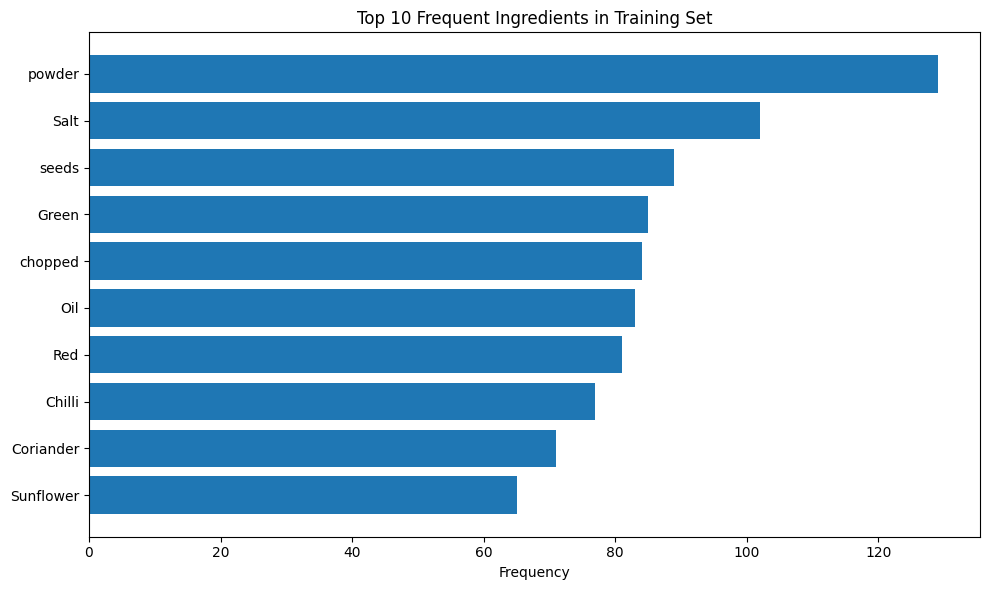

In [365]:
# plot the top frequent ingredients in training data
plot_top_items(top_ingredients, pos_label='ingredient', dataset_name='Training')

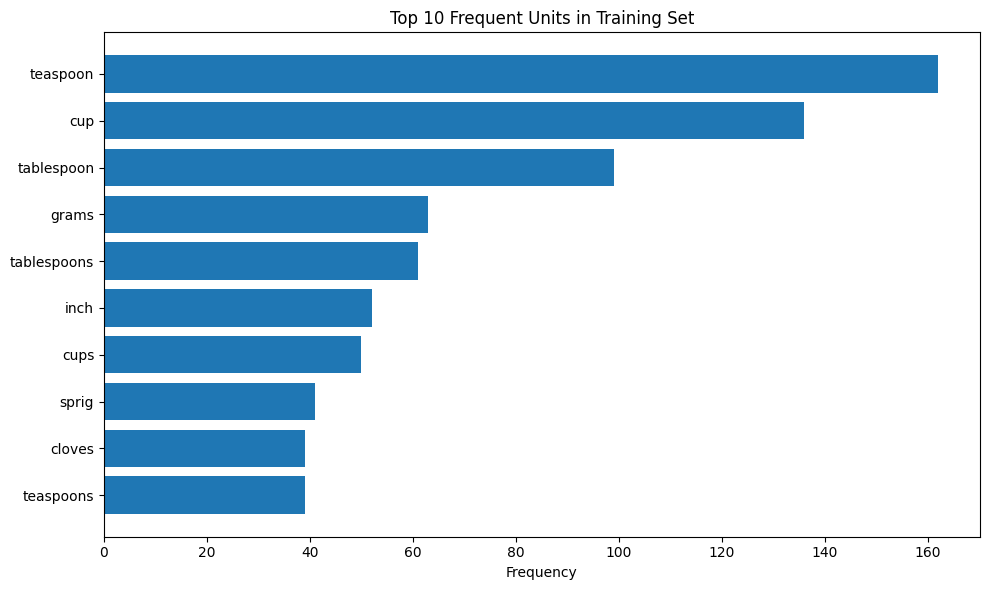

In [366]:
# plot the top frequent units in training data
plot_top_items(top_units, pos_label='unit', dataset_name='Training')

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [367]:
# initialise the dataset_name
dataset_name="Validation"

In [368]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe
extract_and_validate_tokens(val_df, dataset_name)

# Step 1: Aggregate all tokens and tags across the entire dataset
all_tokens = flatten_list(val_df['input_tokens'].tolist(), dataset_name='Validation - input_tokens')
all_tags   = flatten_list(val_df['pos_tokens'].tolist(), dataset_name='Validation - pos_tokens')

# Step 2: Categorize all tokens by their tags
ingredients, units, quantities = categorize_tokens(all_tokens, all_tags)

Flattened Validation - input_tokens data: 2876 total elements.
Flattened Validation - pos_tokens data: 2876 total elements.
Validation dataset is valid. Total token-label pairs: 2876

First 10 token-label from Validation:
1                    --> quantity
cup                  --> unit
Ada                  --> ingredient
2                    --> quantity
liter                --> unit
Milk                 --> ingredient
3/4                  --> quantity
Sugar                --> ingredient
tablespoon           --> unit
Ghee                 --> ingredient
Flattened Validation - input_tokens data: 2876 total elements.
Flattened Validation - pos_tokens data: 2876 total elements.



 Top 10 frequent ingredients in Validation dataset:
powder               --> 54 times
Salt                 --> 47 times
Oil                  --> 39 times
Red                  --> 39 times
seeds                --> 36 times
Chilli               --> 36 times
chopped              --> 31 times
Green                --> 30 times
Leaves               --> 29 times
Coriander            --> 27 times


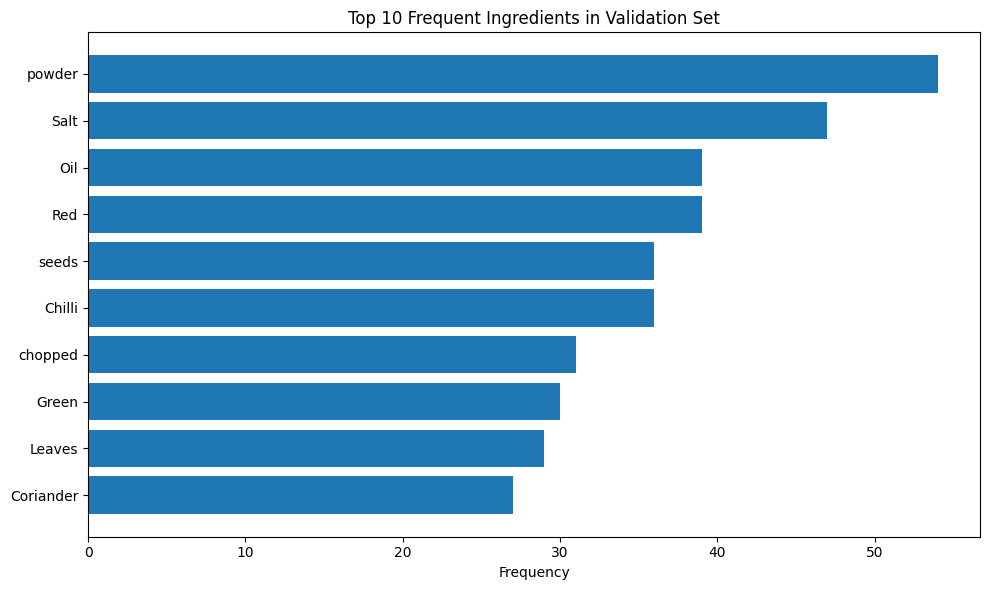

In [369]:
# plot the top frequent ingredients in validation data
top_ingredients = get_top_frequent_items(ingredients, pos_label='ingredient', dataset_name='Validation')
plot_top_items(top_ingredients, pos_label='ingredient', dataset_name='Validation')


 Top 10 frequent units in Validation dataset:
teaspoon             --> 59 times
cup                  --> 57 times
tablespoon           --> 32 times
tablespoons          --> 32 times
cups                 --> 24 times
sprig                --> 21 times
inch                 --> 20 times
grams                --> 19 times
teaspoons            --> 18 times
cloves               --> 16 times


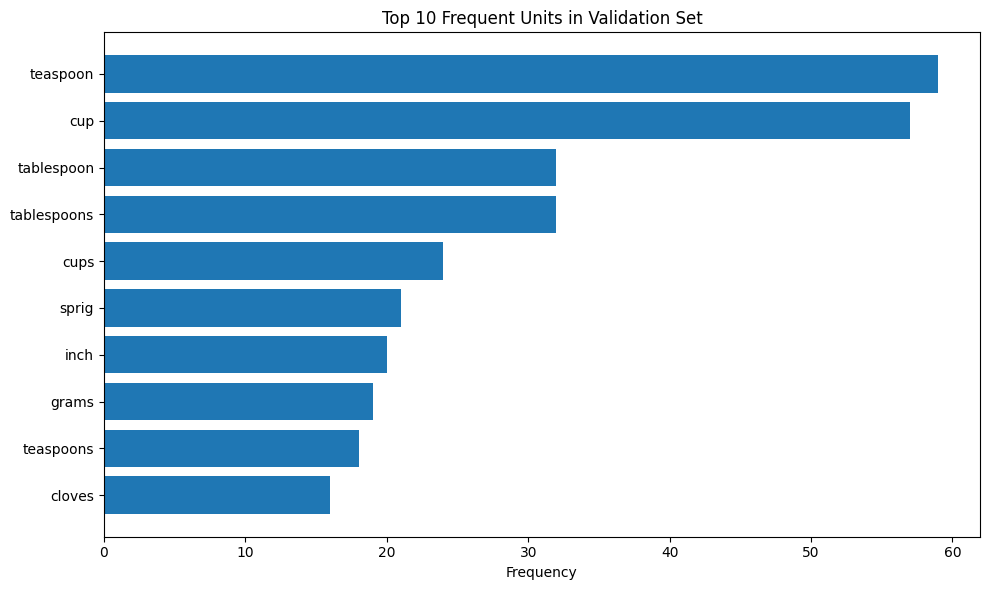

In [370]:
# plot the top frequent units in training data
top_units       = get_top_frequent_items(units, pos_label='unit', dataset_name='Validation')
plot_top_items(top_units, pos_label='unit', dataset_name='Validation')

## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [371]:
# define unit and quantity keywords along with quantity pattern

unit_keywords = {
    "cup", "cups", "tablespoon", "tablespoons", "tbsp", "teaspoon", "teaspoons", "tsp",
    "gram", "grams", "g", "kg", "ml", "l", "oz", "pound", "pounds", "pinch", "dash",
    "liter", "liters", "milliliter", "milliliters", "quart", "quarts", "pint", "pints",
    "can", "cans", "clove", "cloves", "stick", "sticks", "slice", "slices", "bunch"
}

quantity_keywords = {
    "half", "quarter", "third", "one", "two", "three", "four", "five", "six", "seven",
    "eight", "nine", "ten", "eleven", "twelve", "dozen", "few", "some"
}

quantity_pattern = r'(?:(?:\d+\s+)?\d+/\d+|\d+\.\d+|\d+)'

# Compile regex
quantity_regex = re.compile(quantity_pattern)

In [372]:
# # load spaCy model

# nlp = spacy.load("en_core_web_sm")

# # --------------------------
# # 4. Example: Process one sentence
# # --------------------------
# example_sentence = "Add 1 1/2 cups of flour and a quarter teaspoon of salt."

# doc = nlp(example_sentence)

# print("Tokens and POS Tags:")
# for token in doc:
#     print(f"{token.text:15} -> {token.pos_:10} | IsUnit: {token.text.lower() in unit_keywords} | IsQtyKeyword: {token.text.lower() in quantity_keywords} | IsQtyMatch: {bool(quantity_regex.fullmatch(token.text))}")


##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [373]:
# define word2features for processing each token in the sentence sent by using index i.

def word2features(sent, i):
    
    token = sent[i]
    word = token.text
    lower = word.lower()

    # --- Core Features ---

    features = {
        'bias': 1.0,
        'token': lower,
        'lemma': token.lemma_.lower(),
        'pos_tag': token.pos_,
        'tag': token.tag_,
        'dep': token.dep_,
        'shape': token.shape_,
        'is_stop': token.is_stop,
        'is_digit': word.isdigit(),
        'has_digit': any(char.isdigit() for char in word),
        'has_alpha': any(char.isalpha() for char in word),
        'hyphenated': '-' in word,
        'slash_present': '/' in word,
        'is_title': word.istitle(),
        'is_upper': word.isupper(),
        'is_punct': token.is_punct,

        # Improved Quantity and Unit Detection
        'is_quantity': bool(quantity_regex.fullmatch(word)) or lower in quantity_keywords,
        'is_unit': lower in unit_keywords,
        'is_numeric': word.replace('.', '', 1).isdigit(),
        'is_fraction': '/' in word and all(part.isdigit() for part in word.split('/') if part),
        'is_decimal': '.' in word and word.replace('.', '', 1).isdigit(),

        # Preceding & Following Word
        'preceding_word': sent[i - 1].text.lower() if i > 0 else '',
        'following_word': sent[i + 1].text.lower() if i < len(sent) - 1 else '',
    }

    # Contextual Features: Previous Token
    if i > 0:
        prev = sent[i - 1].text.lower()
        features.update({
            'prev_token': prev,
            'prev_is_quantity': bool(quantity_regex.fullmatch(prev)) or prev in quantity_keywords,
            'prev_is_digit': prev.isdigit(),
        })
    else:
        features['BOS'] = True

    # Contextual Features: Next Token
    if i < len(sent) - 1:
        nxt = sent[i + 1].text.lower()
        features.update({
            'next_token': nxt,
            'next_is_unit': nxt in unit_keywords,
            'next_is_ingredient': nxt not in unit_keywords and nxt not in quantity_keywords,
        })
    else:
        features['EOS'] = True

    return features

# nlp = spacy.load("en_core_web_sm")

# doc = nlp("Add 1 1/2 cups of flour and a quarter teaspoon of salt.")

# for i, token in enumerate(doc):
#     feats = word2features(doc, i)
#     print(f"\nToken: {token.text}")
#     for k, v in feats.items():
#         print(f"  {k}: {v}")

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [374]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):    
    return [word2features(sent, i) for i in range(len(sent))]


### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [375]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features

import spacy
nlp = spacy.load("en_core_web_sm")

# Build training features & labels with token-label alignment
X_train_features = []
y_train_labels_cleaned = []

for tokens, labels in zip(train_df["input_tokens"], train_df["pos_tokens"]):
    doc = nlp(" ".join(tokens))
    if len(doc) == len(labels):
        features = sent2features(doc)
        X_train_features.append(features)
        y_train_labels_cleaned.append(labels)

# Build validation features & labels
X_val_features = []
y_val_labels_cleaned = []

for tokens, labels in zip(val_df["input_tokens"], val_df["pos_tokens"]):
    doc = nlp(" ".join(tokens))
    if len(doc) == len(labels):
        features = sent2features(doc)
        X_val_features.append(features)
        y_val_labels_cleaned.append(labels)

# Summary
print("Train feature sets:", len(X_train_features))
print("Validation feature sets:", len(X_val_features))


Train feature sets: 149
Validation feature sets: 55


##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [376]:
# Convert labels into list as y_train_labels and y_val_labels

y_train_labels = y_train_labels_cleaned
y_val_labels = y_val_labels_cleaned

# Summary check
print("y_train_labels count:", len(y_train_labels))
print("y_val_labels count:", len(y_val_labels))


y_train_labels count: 149
y_val_labels count: 55


##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [377]:
# print the length of train features and labels
print("Length of X_train_features:", len(X_train_features))
print("Length of y_train_labels:", len(y_train_labels))
# Print summary

print("Sample y_train_labels[0]:", y_train_labels[0])

Length of X_train_features: 149
Length of y_train_labels: 149
Sample y_train_labels[0]: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


In [378]:
# print the length of validation features and labels

print("Length of X_val_features:", len(X_val_features))
print("Length of y_val_labels:", len(y_val_labels))

Length of X_val_features: 55
Length of y_val_labels: 55


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [379]:
# Flatten labels in y_train

flat_y_train_labels = flatten_list(y_train_labels, dataset_name="Training Labels")

# Display a few sample labels
print(flat_y_train_labels[:20])

Flattened Training Labels data: 5069 total elements.
['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'unit']


##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [380]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
label_counts = Counter(flat_y_train_labels)

# Calculate total number of label tokens
total_samples = sum(label_counts.values())

print("Label Counts:", label_counts)
print("Total Samples:", total_samples)

Label Counts: Counter({'ingredient': 3785, 'quantity': 699, 'unit': 585})
Total Samples: 5069


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [381]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
weight_dict = {label: 1.0 / count for label, count in label_counts.items()}

# Display
print("Weight Dictionary (inverse freq):")
print(weight_dict)

Weight Dictionary (inverse freq):
{'quantity': 0.001430615164520744, 'unit': 0.0017094017094017094, 'ingredient': 0.0002642007926023778}


In [382]:
# penalise ingredient label

penalty_factor = 2.0
if 'ingredient' in weight_dict:
    weight_dict['ingredient'] *= penalty_factor

print("Penalized Weight Dictionary:")
for k, v in weight_dict.items():
    print(f"{k}: {v:.6f}")

Penalized Weight Dictionary:
quantity: 0.001431
unit: 0.001709
ingredient: 0.000528


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [383]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
    
    weighted_features = []

    for sentence_tokens, sentence_labels in zip(X, y):
        features = sent2features(sentence_tokens)
        for feat, label in zip(features, sentence_labels):
            feat['class_weight'] = weight_dict.get(label, 1.0)  # fallback to 1.0
        weighted_features.append(features)

    return weighted_features


##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [384]:
# Re-tokenize only the aligned token sets
train_docs_cleaned = [nlp(" ".join(tokens)) for tokens in train_df["input_tokens"]]
val_docs_cleaned = [nlp(" ".join(tokens)) for tokens in val_df["input_tokens"]]

# Only keep aligned pairs
train_docs_final = []
for tokens, labels in zip(train_df["input_tokens"], train_df["pos_tokens"]):
    doc = nlp(" ".join(tokens))
    if len(doc) == len(labels):
        train_docs_final.append(doc)

val_docs_final = []
for tokens, labels in zip(val_df["input_tokens"], val_df["pos_tokens"]):
    doc = nlp(" ".join(tokens))
    if len(doc) == len(labels):
        val_docs_final.append(doc)


In [385]:
# Apply manually computed class weights

X_train_weighted_features = extract_features_with_class_weights(train_docs_final, y_train_labels, weight_dict)
X_val_weighted_features   = extract_features_with_class_weights(val_docs_final, y_val_labels, weight_dict)
#print(len(X_train_weighted_features))

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [386]:
# initialise CRF model with the specified hyperparameters and use weight_dict

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True,
    verbose=True
)

# train the CRF model with the weighted training data
crf.fit(X_train_weighted_features, y_train_labels)


loading training data to CRFsuite: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 5751.97it/s]


Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 5006
Seconds required: 0.008

L-BFGS optimization
c1: 0.500000
c2: 1.000000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.00  loss=2700.02  active=4491  feature_norm=1.00
Iter 2   time=0.00  loss=2160.69  active=3333  feature_norm=1.09
Iter 3   time=0.00  loss=1095.47  active=2745  feature_norm=2.06
Iter 4   time=0.00  loss=870.35   active=2517  feature_norm=2.43
Iter 5   time=0.00  loss=657.35   active=2239  feature_norm=3.20
Iter 6   time=0.00  loss=517.68   active=1931  feature_norm=4.01
Iter 7   time=0.00  loss=399.84   active=1372  feature_norm=5.01
Iter 8   time=0.00  loss=348.18   active=1065  feature_norm=6.01
Iter 9   time=0.00  loss=320.14   active=1096  feature_norm=6.20
Iter 10  time=0

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5, c2=1.0,
    max_iterations=100, verbose=True)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [387]:
# evaluate on the training dataset

y_train_pred = crf.predict(X_train_weighted_features)



In [388]:
# specify the flat classification report by using training data for evaluation

print(metrics.flat_classification_report(y_train_labels, y_train_pred, digits=3))

              precision    recall  f1-score   support

  ingredient      0.993     0.997     0.995      3785
    quantity      0.999     0.981     0.990       699
        unit      0.981     0.974     0.978       585

    accuracy                          0.992      5069
   macro avg      0.991     0.984     0.987      5069
weighted avg      0.992     0.992     0.992      5069



In [389]:
# create a confusion matrix on training datset

flat_y_train_true = [label for sent in y_train_labels for label in sent]
flat_y_train_pred = [label for sent in y_train_pred for label in sent]

# Generate confusion matrix
labels = sorted(list(set(flat_y_train_true)))
cm = confusion_matrix(flat_y_train_true, flat_y_train_pred, labels=labels)

print(cm)


[[3773    1   11]
 [  13  686    0]
 [  15    0  570]]


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [390]:
# dump the model using joblib as crf_model.pkl

joblib.dump(crf, "crf_model.pkl")

print("CRF model saved as crf_model.pkl")

CRF model saved as crf_model.pkl


## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [391]:
# predict the crf model on validation dataset

# Predict labels for the validation set
y_val_pred = crf.predict(X_val_weighted_features)

# Display the first few predictions
for i in range(3):
    print(f"\nSentence {i+1}")
    print("Tokens:     ", " ".join([token.text for token in val_docs_final[i]]))
    print("True Labels:", y_val_labels[i])
    print("Pred Labels:", y_val_pred[i])



Sentence 1
Tokens:      1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi
True Labels: ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient']
Pred Labels: ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient']

Sentence 2
Tokens:      1 cup green peas gram flour 1/2 cheese tsp ginger 2 chillies turmeric powder cumin teaspoon salt oil
True Labels: ['quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'ingredient']
Pred Labels: ['quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient',

In [392]:
# specify flat classification report

print(metrics.flat_classification_report(y_val_labels, y_val_pred, digits=3))


              precision    recall  f1-score   support

  ingredient      0.986     0.994     0.990      1237
    quantity      0.996     0.976     0.986       253
        unit      0.959     0.937     0.948       222

    accuracy                          0.984      1712
   macro avg      0.980     0.969     0.974      1712
weighted avg      0.984     0.984     0.984      1712



In [393]:
# create a confusion matrix on validation dataset
flat_y_val_true = [label for sent in y_val_labels for label in sent]
flat_y_val_pred = [label for sent in y_val_pred for label in sent]

# Generate confusion matrix
labels = sorted(list(set(flat_y_val_true)))
cm = confusion_matrix(flat_y_val_true, flat_y_val_pred, labels=labels)

print(cm)


[[1229    1    7]
 [   4  247    2]
 [  14    0  208]]


## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [394]:
# flatten Labels and Initialise Error Data
# Flatten true and predicted labels for validation set
flat_y_val_true = [label for sent in y_val_labels for label in sent]
flat_y_val_pred = [label for sent in y_val_pred for label in sent]

# Initialize list to store error analysis
error_data = []

# Summary
print(f"Total tokens in validation set: {len(flat_y_val_true)}")


Total tokens in validation set: 1712


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [395]:
# iterate and collect Error Information

# get previous and next tokens with handling for boundary cases

# Initialize error_data list
error_data = []

# Iterate through validation samples
for sent_idx, (true_labels, pred_labels, doc) in enumerate(zip(y_val_labels, y_val_pred, val_docs_final)):
    for i, (true, pred) in enumerate(zip(true_labels, pred_labels)):
        if true != pred:
            token = doc[i].text
            prev_token = doc[i - 1].text if i > 0 else "<START>"
            next_token = doc[i + 1].text if i < len(doc) - 1 else "<END>"
            
            error_data.append({
                "sentence_index": sent_idx,
                "token_index": i,
                "token": token,
                "true_label": true,
                "predicted_label": pred,
                "previous_token": prev_token,
                "next_token": next_token,
                "context": f"{prev_token} {token} {next_token}"
            })

# Summary
print(f"Total errors collected: {len(error_data)}")


Total errors collected: 28


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [396]:
# Create DataFrame and Print Overall Accuracy
error_df = pd.DataFrame(error_data)

from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(flat_y_val_true, flat_y_val_pred)

print("Validation Accuracy: {:.2f}%".format(val_accuracy * 100))
error_df


Validation Accuracy: 98.36%


sentence_index  token_index      token  true_label predicted_label previous_token   next_token                      context
0                2           18     cloves  ingredient            unit              3       garlic              3 cloves garlic
1                2           21      Spoon        unit      ingredient            big          oil                big Spoon oil
2                7            3         is    quantity      ingredient            Pur            2                     Pur is 2
3                9           56        few  ingredient        quantity         Leaves        <END>             Leaves few <END>
4               10           25         to    quantity      ingredient          sugar  tablespoons         sugar to tablespoons
5               13           26        for    quantity      ingredient            Oil     kneading             Oil for kneading
6               15           24  julienned        unit      ingredient         Ginger   tablespoon  Ginger julienned tablespoon
7               18           17     slices  ingredient            unit         pepper    Coriander      pepper slices Coriander
8               27           17          a    quantity      ingredient          sugar        pinch                sugar a pinch
9               32            3      small        unit      ingredient              6       onions               6 small onions
10              32            6        bud        unit      ingredient             10       garlic                10 bud garlic
11              32            9      green        unit      ingredient              2     chillies             2 green chillies
12              36            3     medium        unit      ingredient       Potatoes            1            Potatoes medium 1
13              36           13          a        unit      ingredient          Haldi        pinch                Haldi a pinch
14              37           13     cloves  ingredient            unit              4       garlic              4 cloves garlic
15              40           13      pinch    quantity            unit            Dal   Asafoetida         Dal pinch Asafoetida
16              41           20     sprigs        unit      ingredient            oil           of                oil sprigs of
17              44           34      pound  ingredient            unit       coarsely        sprig         coarsely pound sprig
18              46            6        dry        unit      ingredient              4          red                    4 dry red
19              46            7        red        unit      ingredient            dry     chillies             dry red chillies
20              47            9     cloves    quantity            unit       Tomatoes       Garlic       Tomatoes cloves Garlic
21              50            4      small        unit      ingredient             12       onions              12 small onions
22              50            7     cloves  ingredient            unit              2       garlic              2 cloves garlic
23              50           11      green        unit      ingredient         ginger     chillies        ginger green chillies
24              52           13     cloves  ingredient            unit              6       garlic              6 cloves garlic
25              52           20      Sprig        unit      ingredient              2        <END>                2 Sprig <END>
26              53           27       Tbsp        unit      ingredient          sugar        honey             sugar Tbsp honey
27              54            7       gram  ingredient            unit          black     teaspoon          black gram teaspoon

##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [397]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

# Analyze errors per label
error_counts = error_df.groupby("true_label").size().to_dict()
true_label_counts = Counter(flat_y_val_true)

label_analysis = []
for label in sorted(true_label_counts.keys()):
    total = true_label_counts[label]
    errors = error_counts.get(label, 0)
    correct = total - errors
    accuracy = correct / total
    weight = weight_dict.get(label, 1.0)
    label_analysis.append({
        "Label": label,
        "Total": total,
        "Errors": errors,
        "Correct": correct,
        "Accuracy (%)": round(accuracy * 100, 2),
        "Class Weight": round(weight, 4)
    })

label_analysis_df = pd.DataFrame(label_analysis).sort_values(by="Errors", ascending=False)

# Display the label-wise error analysis using print
print("\nLabel-wise Validation Error Analysis:")
print(label_analysis_df.to_string(index=False))

# Show top 20 misclassified tokens
print("\nTop 20 Misclassified Tokens (with context):")
print(error_df[["token", "previous_token", "next_token", "true_label", "predicted_label", "context"]].head(20).to_string(index=False))


Label-wise Validation Error Analysis:
     Label  Total  Errors  Correct  Accuracy (%)  Class Weight
      unit    222      14      208         93.69        0.0017
ingredient   1237       8     1229         99.35        0.0005
  quantity    253       6      247         97.63        0.0014

Top 20 Misclassified Tokens (with context):
    token previous_token  next_token true_label predicted_label                     context
   cloves              3      garlic ingredient            unit             3 cloves garlic
    Spoon            big         oil       unit      ingredient               big Spoon oil
       is            Pur           2   quantity      ingredient                    Pur is 2
      few         Leaves       <END> ingredient        quantity            Leaves few <END>
       to          sugar tablespoons   quantity      ingredient        sugar to tablespoons
      for            Oil    kneading   quantity      ingredient            Oil for kneading
julienned         Gi

### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

In [399]:
# Overall Model Performance
# The model achieved a high validation accuracy of 98.36% on 1712 tokens. 
# This indicates that the CRF model has learned to generalize well on unseen recipe inputs.
# The ingredient tag has the highest accuracy, suggesting that ingredient names are more consistent and recognizable across the dataset.


## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.